# Download Dataset

In [1]:
#Mendownload dataset
!gdown 1LbxDZJu7S4rZMRACX3YX5PKxJ31OR0Xv -O data/dataset.zip

#Melakukan unzip file dataset
!unzip -q data/dataset.zip -d data/

#Menghapus file zip
!rm -rf data/dataset.zip

Downloading...
From (original): https://drive.google.com/uc?id=1LbxDZJu7S4rZMRACX3YX5PKxJ31OR0Xv
From (redirected): https://drive.google.com/uc?id=1LbxDZJu7S4rZMRACX3YX5PKxJ31OR0Xv&confirm=t&uuid=c07fd20d-6a2e-4270-a4dc-f76d84c35af9
To: /home/abiyamf/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitTanamanApel/data/dataset.zip
100%|████████████████████████████████████████| 864M/864M [02:59<00:00, 4.82MB/s]


# Split Dataset

In [2]:
!python utils/example.py

Pemisahan file gambar berdasarkan class selesai!
split_dataset_utama done
Pemisahan dan penggabungan file gambar dari data/ROOT/train dan data/ROOT/test berdasarkan class selesai!
split_dataset_utama_versi_submission done
Class 'rust' telah dibagi ke dalam train, val, dan test.
Class 'scab' telah dibagi ke dalam train, val, dan test.
Class 'multiple_diseases' telah dibagi ke dalam train, val, dan test.
Class 'healthy' telah dibagi ke dalam train, val, dan test.
Pembagian dataset selesai!
split_utama done
Class 'rust' telah dibagi ke dalam train, val, dan test.
Class 'scab' telah dibagi ke dalam train, val, dan test.
Class 'multiple_diseases' telah dibagi ke dalam train, val, dan test.
Class 'healthy' telah dibagi ke dalam train, val, dan test.
Pembagian dataset selesai!
split_utama_versi_submission done
Class 'Black Rot' telah dibagi ke dalam train, val, dan test.
Class 'Scab' telah dibagi ke dalam train, val, dan test.
Class 'Cedar Rust' telah dibagi ke dalam train, val, dan test.
Cla

# Import Library

In [1]:
# Import library yang digunakan untuk keseluruhan dataset
import os
import random
import shutil
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Dense, Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

# Import model arsitektur dan preprocess input untuk MobileNet dan EfficientNet
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

2024-10-16 16:02:07.699806: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 16:02:07.866926: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 16:02:07.921636: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 16:02:08.231773: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-16 16:02:10.431406: W tensorflow/compiler/tf2

# EDA

In [2]:
# Cek apakah GPU tersedia
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Atur batas memori GPU (dalam byte)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=20480)]  # 20GB dalam megabyte
        )
        print(f"Batas VRAM berhasil diatur: {20480 / 1024} GB")
    except RuntimeError as e:
        print(e)

Batas VRAM berhasil diatur: 20.0 GB


In [5]:
# Daftar model EfficientNet yang akan dihitung jumlah layernya
efficientnet_variants = [
    EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3,
    EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
]

# List untuk menyimpan hasil jumlah layer
model_layers_count = []

# Loop melalui setiap varian dan hitung jumlah layer
for variant in efficientnet_variants:
    model_name = variant.__name__  # Mendapatkan nama model
    model = variant(weights='imagenet')  # Menggunakan weights 'imagenet'
    layer_count = len(model.layers)  # Menghitung jumlah layer
    model_layers_count.append((model_name, layer_count))  # Menyimpan hasil ke list

# Membuat dataframe dari hasil yang diperoleh
df_layers = pd.DataFrame(model_layers_count, columns=['Model', 'Number of Layers'])

# Menampilkan tabel jumlah layer
print(df_layers)

2024-10-10 15:54:54.061364: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20480 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


268326632/268326632 [==============================] - 3s 0us/step
            Model  Number of Layers
0  EfficientNetB0               241
1  EfficientNetB1               343
2  EfficientNetB2               343
3  EfficientNetB3               388
4  EfficientNetB4               478
5  EfficientNetB5               580
6  EfficientNetB6               670
7  EfficientNetB7               817


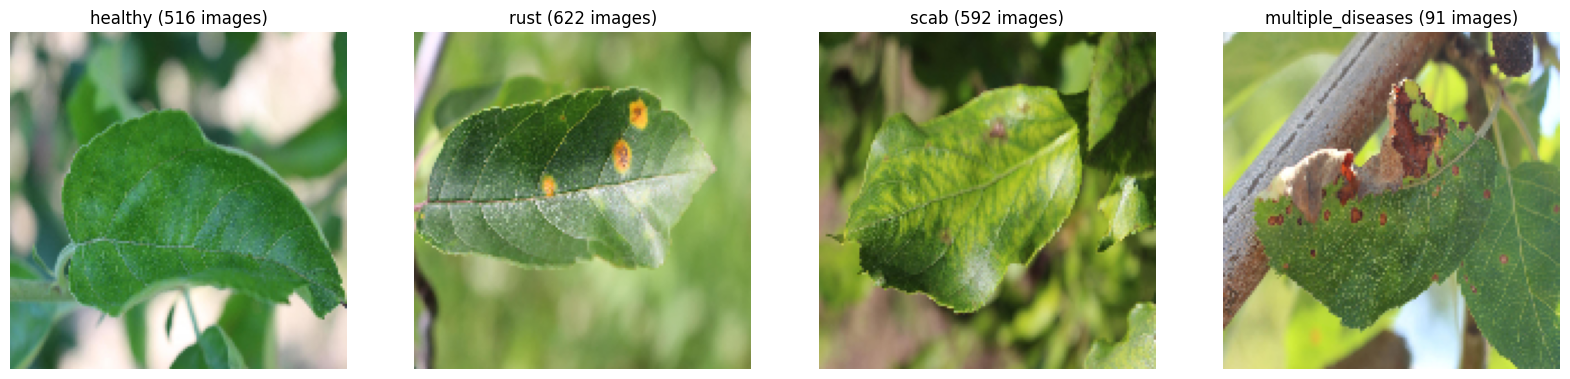

In [6]:
# Path ke folder dataset utama
base_path = 'data/original_dataset_utama/train'

# Daftar kelas yang ingin ditampilkan
classes = ['healthy', 'rust', 'scab', 'multiple_diseases']

# Membuat figure dengan subplot
fig, ax = plt.subplots(1, len(classes), figsize=(20, 5))

# Iterasi untuk setiap kelas
for i, class_name in enumerate(classes):
    class_folder = os.path.join(base_path, class_name)
    
    # Menghitung jumlah gambar di setiap kelas
    num_images = len([file for file in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, file))])
    
    # Memilih gambar sample untuk ditampilkan
    sample_image = os.listdir(class_folder)[0]
    img_path = os.path.join(class_folder, sample_image)
    
    # Memuat dan menampilkan gambar
    img = image.load_img(img_path, target_size=(150, 150))
    ax[i].imshow(img)
    ax[i].axis('off')
    
    # Mengatur judul dengan menambahkan nama kelas dan jumlah gambar
    ax[i].set_title(f"{class_name} ({num_images} images)")

# Menampilkan hasil plot
plt.show()

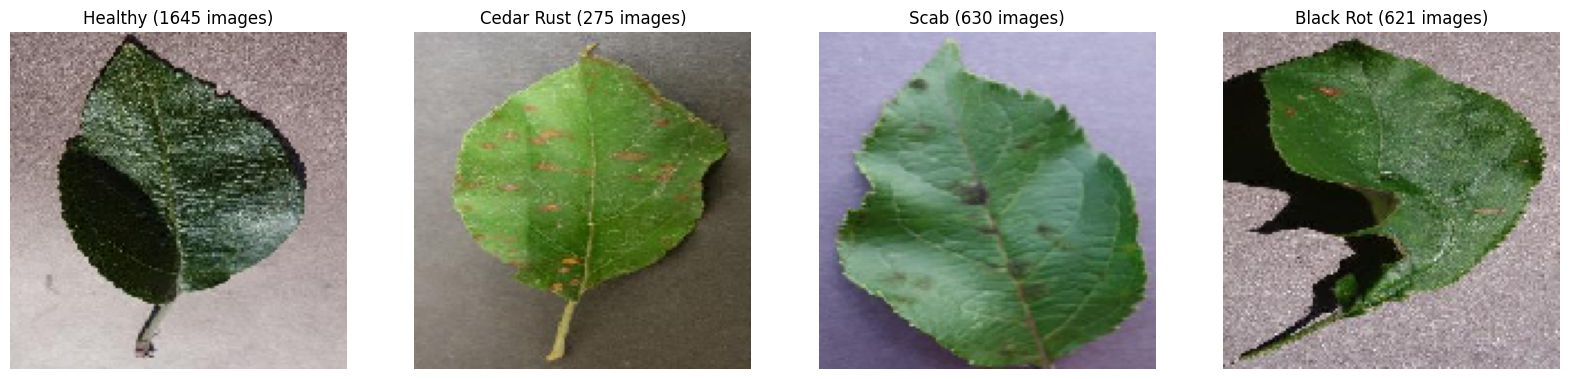

In [7]:
# Path ke folder dataset utama
base_path = 'data/original_dataset_cadangan'

# Daftar kelas yang ingin ditampilkan
classes = ['Healthy', 'Cedar Rust', 'Scab', 'Black Rot']

# Membuat figure dengan subplot
fig, ax = plt.subplots(1, len(classes), figsize=(20, 5))

# Iterasi untuk setiap kelas
for i, class_name in enumerate(classes):
    class_folder = os.path.join(base_path, class_name)
    num_images = len([file for file in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, file))])
    sample_image = os.listdir(class_folder)[0]
    img_path = os.path.join(class_folder, sample_image)
    img = image.load_img(img_path, target_size=(150, 150))
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(f"{class_name} ({num_images} images)")

plt.show()

# Define Fungsi

In [2]:
def augment_and_resize_dataset(base_path, img_size, batch_size, preprocess_input_func=None):
    train_path = os.path.join(base_path, 'train')
    validation_path = os.path.join(base_path, 'val')
    test_path = os.path.join(base_path, 'test')

    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input_func,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Untuk data validation dan test, hanya preprocessing
    validation_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_func)

    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    validation_generator = validation_test_datagen.flow_from_directory(
        validation_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = validation_test_datagen.flow_from_directory(
        test_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

In [3]:
def build_and_compile_model_not_trainable(base_model_class, input_shape, num_classes):
    base_model = base_model_class(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    inputs = Input(shape=input_shape)
    
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [4]:
def build_and_compile_model_trainable(base_model_class, input_shape, num_classes):
    base_model = base_model_class(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = True

    # Freeze 85% layer pertama dari base model
    total_layers = len(base_model.layers)
    freeze_layers = int(0.85 * total_layers)
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False

    inputs = Input(shape=input_shape)
    
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)


    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [5]:
# Fungsi untuk melatih model dan menampilkan grafik serta menyimpannya
def train_and_plot(model, model_name, train_generator, validation_generator, test_generator, epochs, save_directory):
    # Membuat folder penyimpanan jika belum ada
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    # Membuat folder untuk menyimpan gambar
    images_save_directory = os.path.join(save_directory, 'images')
    if not os.path.exists(images_save_directory):
        os.makedirs(images_save_directory)

    # Menyusun nama file penyimpanan model dengan parameter model_name
    save_path = os.path.join(save_directory, f'best_model_{model_name}.keras')

    # Callback untuk menyimpan model terbaik berdasarkan akurasi pada data validasi
    checkpoint_callback = ModelCheckpoint(save_path, monitor='val_accuracy', save_best_only=True, mode='max')

    # Callback untuk menghentikan pelatihan jika tidak ada perbaikan setelah beberapa epoch
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Menghitung waktu mulai pelatihan
    start_time = time.time()
    
    # Melatih model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=[checkpoint_callback, early_stopping_callback]
    )
    
    # Menghitung waktu selesai pelatihan
    end_time = time.time()
    
    # Menghitung durasi pelatihan
    training_duration = end_time - start_time  # dalam detik

    # Plotting hasil akurasi
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Save the loss plot
    plt.savefig(os.path.join(images_save_directory, f'{model_name}_accuracy_loss.png'))

    # Tampilkan plot
    plt.show()

    # Evaluasi model pada data test
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Prediksi pada data test
    y_pred = model.predict(test_generator)

    # Mengambil index dari prediksi (kelas dengan probabilitas tertinggi)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Mengambil label sebenarnya dari generator
    y_true = test_generator.classes

    # Membuat confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    class_names = list(test_generator.class_indices.keys())

    # Menampilkan classification report
    print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))

    # Plot confusion matrix sebagai heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Save the confusion matrix plot
    plt.savefig(os.path.join(images_save_directory, f'{model_name}_confusion_matrix.png'))

    # Tampilkan confusion matrix
    plt.close()
    # plt.show()

    return history, test_loss, test_accuracy, training_duration


In [6]:
# Fungsi untuk menyimpan hasil evaluasi ke dalam dictionary dan menampilkan dalam tabel
def store_results(model_name, history, test_loss, test_accuracy, training_duration, results_dict, csv_filename):
    # Menyimpan nama model
    results_dict['Model'].append(model_name)
    
    # Mengambil akurasi dan loss tertinggi dari history untuk training dan validation
    max_train_acc = max(history.history['accuracy']) if 'accuracy' in history.history else None
    max_val_acc = max(history.history['val_accuracy']) if 'val_accuracy' in history.history else None
    
    results_dict['Train Accuracy'].append(max_train_acc)
    results_dict['Train Loss'].append(min(history.history['loss']) if 'loss' in history.history else None)
    results_dict['Validation Accuracy'].append(max_val_acc)
    results_dict['Validation Loss'].append(min(history.history['val_loss']) if 'val_loss' in history.history else None)

    # Menyimpan training duration
    results_dict['Training Duration'].append(training_duration)
    
    # Menyimpan hasil evaluasi test loss dan test accuracy
    results_dict['Test Accuracy'].append(test_accuracy)
    results_dict['Test Loss'].append(test_loss)

    # Menyimpan total epoch
    results_dict['Total Epoch'].append(max(history.epoch))
    
    # Simpan hasil ke CSV tanpa menimpa file lama
    file_exists = os.path.isfile(csv_filename)
    
    # Membuat DataFrame dari results_dict
    results_df = pd.DataFrame(results_dict)
    
    # Append ke file CSV
    results_df.to_csv(csv_filename, mode='a', header=not file_exists, index=False)

    # Kosongkan dictionary setelah disimpan ke CSV untuk memulai fresh
    results_dict.clear()
    results_dict.update({
        'Model': [],
        'Train Accuracy': [],
        'Train Loss': [],
        'Validation Accuracy': [],
        'Validation Loss': [],
        'Test Accuracy': [],
        'Test Loss': [],
        'Training Duration': [],
        'Total Epoch': []
    })

# Membuat dictionary untuk menyimpan hasil evaluasi
results_not_trainable = {
    'Model': [],
    'Train Accuracy':[],
    'Train Loss':[],
    'Validation Accuracy':[],
    'Validation Loss':[],
    'Test Accuracy': [],
    'Test Loss': [],
    'Training Duration': [],
    'Total Epoch': []
}

results_trainable = {
    'Model': [],
    'Train Accuracy':[],
    'Train Loss':[],
    'Validation Accuracy':[],
    'Validation Loss':[],
    'Test Accuracy': [],
    'Test Loss': [],
    'Training Duration': [],
    'Total Epoch': []
}

In [7]:
efficientnet_input_shapes = {
    'EfficientNetB0': (224, 224),
    'EfficientNetB1': (240, 240),
    'EfficientNetB2': (260, 260),
    'EfficientNetB3': (300, 300),
    'EfficientNetB4': (380, 380),
    'EfficientNetB5': (456, 456),
    'EfficientNetB6': (528, 528),
    'EfficientNetB7': (600, 600),
}

base_path = "data/split_train_test_dataset_campuran"

preprocess_input_func = efficientnet_preprocess

| Model           | Total Layers | Freeze Layers | Train Layers |
|-----------------|--------------|---------------|--------------|
| EfficientNetB0  | 241          | 204           | 37           |
| EfficientNetB1  | 343          | 291           | 52           |
| EfficientNetB2  | 343          | 291           | 52           |
| EfficientNetB3  | 388          | 329           | 59           |
| EfficientNetB4  | 478          | 406           | 72           |
| EfficientNetB5  | 580          | 493           | 87           |
| EfficientNetB6  | 670          | 569           | 101          |
| EfficientNetB7  | 817          | 694           | 123          |


In [3]:
epochs = 50
batch_size = 16
save_directory_not_trainable = 'best_model_not_trainable/'
save_directory_trainable = 'best_model_trainable/'
csv_filename_not_trainable = 'outputs/results_not_trainable.csv'
csv_filename_trainable = 'outputs/results_trainable.csv'

In [9]:
def sleep_reset():
    tf.keras.backend.clear_session()
    time.sleep(60)

# Not Trainable

## EN B0

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


I0000 00:00:1728968642.331755   10003 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728968642.689087   10003 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728968642.689192   10003 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728968642.692642   10003 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728968642.692749   10003 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Epoch 1/50


I0000 00:00:1728968655.477704   10152 service.cc:146] XLA service 0x7f0d48001af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728968655.477760   10152 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-10-15 12:04:15.891180: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-15 12:04:17.458554: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1728968667.605156   10152 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


87/87 ━━━━━━━━━━━━━━━━━━━━ 69s 549ms/step - accuracy: 0.4884 - loss: 0.9700 - val_accuracy: 0.7989 - val_loss: 0.4705
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 287ms/step - accuracy: 0.8063 - loss: 0.5122 - val_accuracy: 0.8305 - val_loss: 0.3956
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 280ms/step - accuracy: 0.8160 - loss: 0.4315 - val_accuracy: 0.8764 - val_loss: 0.3287
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 280ms/step - accuracy: 0.8353 - loss: 0.3998 - val_accuracy: 0.8937 - val_loss: 0.2841
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 299ms/step - accuracy: 0.8400 - loss: 0.4049 - val_accuracy: 0.9167 - val_loss: 0.2172
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 299ms/step - accuracy: 0.8780 - loss: 0.3199 - val_accuracy: 0.9224 - val_loss: 0.1993
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 269ms/step - accuracy: 0.8650 - loss: 0.3337 - val_accuracy: 0.9224 - val_loss: 0.1946
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 274ms/step - accuracy: 0.8833 - loss: 0.3246 - val_accuracy: 0.905

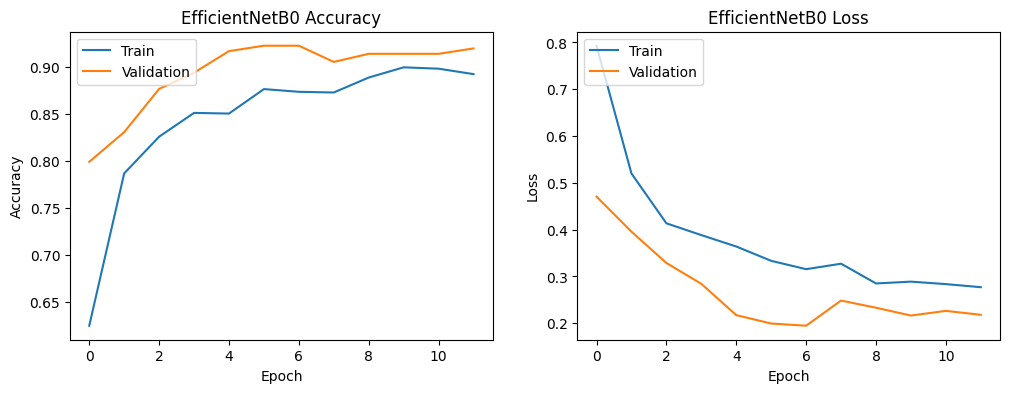

160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9421 - loss: 0.1873
Test Accuracy: 0.7561
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.76      0.99      0.86      1645
        rust       0.69      0.33      0.45       275
        scab       0.72      0.32      0.45       630

    accuracy                           0.76      2550
   macro avg       0.73      0.55      0.59      2550
weighted avg       0.75      0.76      0.72      2550



In [9]:
model_name = 'EfficientNetB0'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

EN_B0 = build_and_compile_model_not_trainable(EfficientNetB0, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B0, test_loss, test_acc, training_duration = train_and_plot(EN_B0, model_name, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory_not_trainable)
store_results(model_name, history_EN_B0, test_loss, test_acc, training_duration, results_not_trainable,csv_filename_not_trainable)

## EN B1

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 84s 645ms/step - accuracy: 0.5228 - loss: 0.9385 - val_accuracy: 0.7989 - val_loss: 0.5053
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 29s 328ms/step - accuracy: 0.7614 - loss: 0.5639 - val_accuracy: 0.8563 - val_loss: 0.3534
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 304ms/step - accuracy: 0.8518 - loss: 0.4222 - val_accuracy: 0.8592 - val_loss: 0.3539
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 292ms/step - accuracy: 0.8376 - loss: 0.4050 - val_accuracy: 0.8506 - val_loss: 0.3441
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 304ms/step - accuracy: 0.8493 - loss: 0.4050 - val_accuracy: 0.8793 - val_loss: 0.2978
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 298ms/step - accuracy: 0.8664 - loss: 0.3354 - val_accuracy: 0.8822 - val_loss: 0.2680
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 306ms/step - accuracy: 0.8782 - loss: 0.3295 - val_accuracy: 0.8851 - val_loss: 0.2743
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 309ms/step - accuracy: 0.8829 - loss: 0.3059 - val_accu

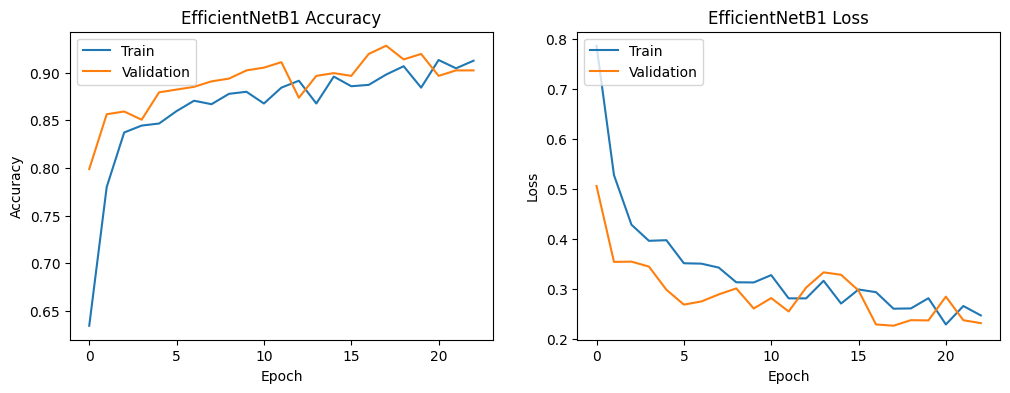

160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9523 - loss: 0.1501
Test Accuracy: 0.7933
160/160 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.81      0.99      0.89      1645
        rust       0.69      0.61      0.65       275
        scab       0.75      0.35      0.48       630

    accuracy                           0.79      2550
   macro avg       0.75      0.65      0.67      2550
weighted avg       0.78      0.79      0.76      2550



In [10]:
model_name = 'EfficientNetB1'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

EN_B1 = build_and_compile_model_not_trainable(EfficientNetB1, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B1, test_loss, test_acc, training_duration = train_and_plot(EN_B1, model_name, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory_not_trainable)
store_results(model_name, history_EN_B1, test_loss, test_acc, training_duration, results_not_trainable, csv_filename_not_trainable)

## EN B2

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


E0000 00:00:1728969713.744593   10150 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728969713.902458   10150 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


19/87 ━━━━━━━━━━━━━━━━━━━━ 19s 281ms/step - accuracy: 0.3648 - loss: 1.0888

E0000 00:00:1728969737.076629   10149 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728969737.218603   10149 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.5341 - loss: 0.9328

E0000 00:00:1728969776.446695   10151 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728969776.597060   10151 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


87/87 ━━━━━━━━━━━━━━━━━━━━ 88s 680ms/step - accuracy: 0.5354 - loss: 0.9312 - val_accuracy: 0.8420 - val_loss: 0.4632
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 28s 319ms/step - accuracy: 0.7793 - loss: 0.5568 - val_accuracy: 0.8448 - val_loss: 0.3752
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 28s 319ms/step - accuracy: 0.8254 - loss: 0.4704 - val_accuracy: 0.8391 - val_loss: 0.4331
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 28s 321ms/step - accuracy: 0.8332 - loss: 0.4225 - val_accuracy: 0.8391 - val_loss: 0.4202
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 28s 327ms/step - accuracy: 0.8526 - loss: 0.3695 - val_accuracy: 0.8678 - val_loss: 0.3507
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 28s 321ms/step - accuracy: 0.8714 - loss: 0.3340 - val_accuracy: 0.8678 - val_loss: 0.3422
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 28s 318ms/step - accuracy: 0.8904 - loss: 0.2970 - val_accuracy: 0.8736 - val_loss: 0.3165
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 28s 324ms/step - accuracy: 0.8838 - loss: 0.3339 - val_accuracy: 0.876

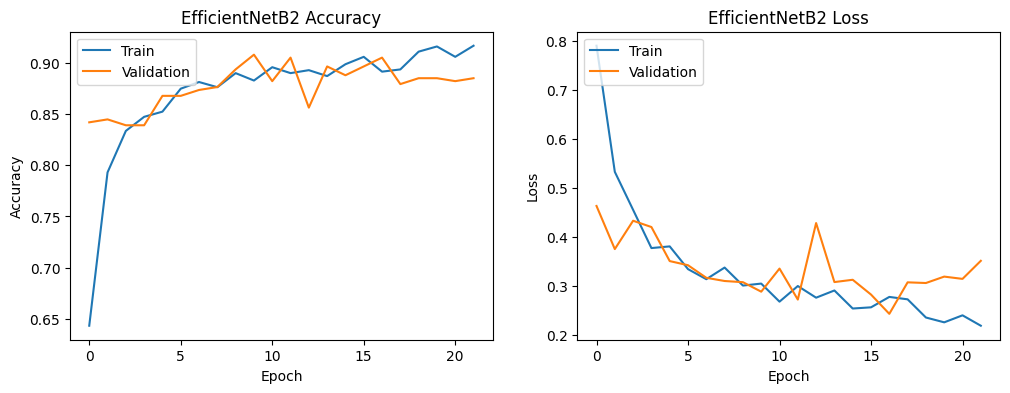

160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.8621 - loss: 0.3808
Test Accuracy: 0.7714
160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.88      0.90      0.89      1645
        rust       0.75      0.17      0.28       275
        scab       0.54      0.69      0.60       630

    accuracy                           0.77      2550
   macro avg       0.72      0.59      0.59      2550
weighted avg       0.78      0.77      0.76      2550



In [11]:
model_name = 'EfficientNetB2'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

EN_B2 = build_and_compile_model_not_trainable(EfficientNetB2, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B2, test_loss, test_acc, training_duration = train_and_plot(EN_B2, model_name, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory_not_trainable)
store_results(model_name, history_EN_B2, test_loss, test_acc, training_duration, results_not_trainable, csv_filename_not_trainable)

## EN B3

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


E0000 00:00:1728970423.358018   10149 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728970423.541004   10149 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


61/87 ━━━━━━━━━━━━━━━━━━━━ 8s 324ms/step - accuracy: 0.5315 - loss: 0.9793

E0000 00:00:1728970466.185403   10152 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728970466.337473   10152 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.5697 - loss: 0.9219

E0000 00:00:1728970500.269026   10151 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728970500.478677   10151 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728970500.611970   10151 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


87/87 ━━━━━━━━━━━━━━━━━━━━ 104s 794ms/step - accuracy: 0.5709 - loss: 0.9200 - val_accuracy: 0.7701 - val_loss: 0.5422
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 39s 448ms/step - accuracy: 0.8027 - loss: 0.5087 - val_accuracy: 0.8420 - val_loss: 0.3983
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 33s 377ms/step - accuracy: 0.8297 - loss: 0.4136 - val_accuracy: 0.8966 - val_loss: 0.2919
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 33s 374ms/step - accuracy: 0.8461 - loss: 0.3909 - val_accuracy: 0.8937 - val_loss: 0.2749
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 33s 373ms/step - accuracy: 0.8566 - loss: 0.3649 - val_accuracy: 0.9052 - val_loss: 0.2517
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 31s 359ms/step - accuracy: 0.8758 - loss: 0.3374 - val_accuracy: 0.8879 - val_loss: 0.2808
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 32s 364ms/step - accuracy: 0.9022 - loss: 0.2729 - val_accuracy: 0.9023 - val_loss: 0.2455
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 33s 374ms/step - accuracy: 0.9094 - loss: 0.2565 - val_accuracy: 0.88

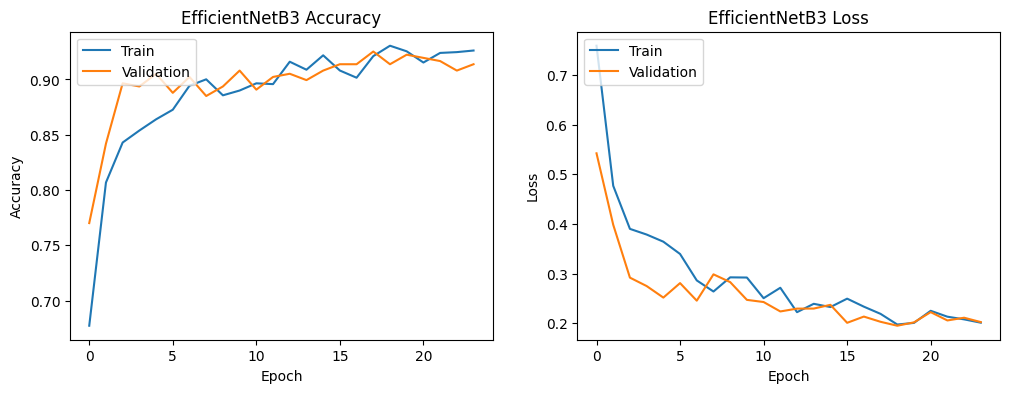

160/160 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - accuracy: 0.8503 - loss: 0.3919
Test Accuracy: 0.8063
160/160 ━━━━━━━━━━━━━━━━━━━━ 24s 98ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.95      0.88      0.91      1645
        rust       0.92      0.25      0.40       275
        scab       0.57      0.87      0.69       630

    accuracy                           0.81      2550
   macro avg       0.81      0.67      0.67      2550
weighted avg       0.85      0.81      0.80      2550



In [12]:
model_name = 'EfficientNetB3'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

EN_B3 = build_and_compile_model_not_trainable(EfficientNetB3, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B3, test_loss, test_acc, training_duration = train_and_plot(EN_B3, model_name, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory_not_trainable)
store_results(model_name, history_EN_B3, test_loss, test_acc, training_duration, results_not_trainable, csv_filename_not_trainable)

## EN B4

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


I0000 00:00:1728978678.392453   15247 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728978678.776306   15247 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728978678.776393   15247 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728978678.781406   15247 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728978678.781511   15247 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Epoch 1/50


I0000 00:00:1728978699.540821   15392 service.cc:146] XLA service 0x7f1d28003f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728978699.540875   15392 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-10-15 14:51:40.269621: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-15 14:51:42.828504: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
E0000 00:00:1728978710.466984   15392 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728978710.636742   15392 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight System

41/87 ━━━━━━━━━━━━━━━━━━━━ 21s 475ms/step - accuracy: 0.5556 - loss: 0.9291

E0000 00:00:1728978757.618769   15392 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728978757.747355   15392 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728978757.902605   15392 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728978758.667240   15392 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - accuracy: 0.6273 - loss: 0.8166

E0000 00:00:1728978810.493722   15389 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728978810.660815   15389 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728978810.838225   15389 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-10-15 14:53:33.974112: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[12,336,48,48]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,336,48,48]{3,2,1,0}, f32[336,1,5,5]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, feature_group_count=336, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wai

87/87 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.6283 - loss: 0.8149 - val_accuracy: 0.8937 - val_loss: 0.3262
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 43s 495ms/step - accuracy: 0.8534 - loss: 0.4083 - val_accuracy: 0.8908 - val_loss: 0.2339
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 45s 513ms/step - accuracy: 0.8852 - loss: 0.3171 - val_accuracy: 0.9023 - val_loss: 0.2415
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 44s 500ms/step - accuracy: 0.8736 - loss: 0.3224 - val_accuracy: 0.9138 - val_loss: 0.2270
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 45s 515ms/step - accuracy: 0.8887 - loss: 0.2998 - val_accuracy: 0.9195 - val_loss: 0.2202
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 43s 489ms/step - accuracy: 0.9001 - loss: 0.2509 - val_accuracy: 0.9080 - val_loss: 0.2196
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 44s 506ms/step - accuracy: 0.8997 - loss: 0.2546 - val_accuracy: 0.9397 - val_loss: 0.1673
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 43s 491ms/step - accuracy: 0.9025 - loss: 0.2417 - val_accuracy: 0.8994 

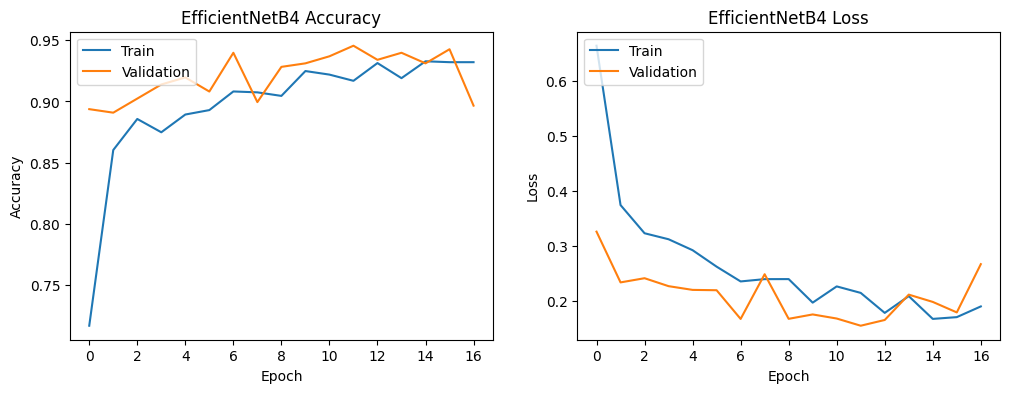

160/160 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - accuracy: 0.9316 - loss: 0.2683
Test Accuracy: 0.7722
160/160 ━━━━━━━━━━━━━━━━━━━━ 36s 171ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.81      0.99      0.89      1645
        rust       0.80      0.13      0.23       275
        scab       0.62      0.49      0.55       630

    accuracy                           0.77      2550
   macro avg       0.75      0.54      0.56      2550
weighted avg       0.76      0.77      0.73      2550



In [10]:
model_name = 'EfficientNetB4'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

EN_B4 = build_and_compile_model_not_trainable(EfficientNetB4, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B4, test_loss, test_acc, training_duration = train_and_plot(EN_B4, model_name, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory_not_trainable)
store_results(model_name, history_EN_B4, test_loss, test_acc, training_duration, results_not_trainable, csv_filename_not_trainable)

## EN B5

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 28s 0us/step


/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


E0000 00:00:1728991442.833674   15390 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728991443.154624   15390 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728991444.334242   15390 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728991444.498680   15390 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728991444.706835   15390 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-

12/87 ━━━━━━━━━━━━━━━━━━━━ 41s 550ms/step - accuracy: 0.3828 - loss: 1.1010

E0000 00:00:1728991488.509201   15388 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728991488.679608   15388 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728991490.655404   15388 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728991490.838388   15388 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728991491.031362   15388 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 917ms/step - accuracy: 0.5214 - loss: 0.9391

E0000 00:00:1728991573.832733   15388 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728991574.024244   15388 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728991577.006062   15388 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728991577.195945   15388 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728991578.196884   15388 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

87/87 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.5229 - loss: 0.9371 - val_accuracy: 0.8506 - val_loss: 0.4032
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 59s 672ms/step - accuracy: 0.8115 - loss: 0.4539 - val_accuracy: 0.9138 - val_loss: 0.2264
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 60s 682ms/step - accuracy: 0.8655 - loss: 0.3652 - val_accuracy: 0.9253 - val_loss: 0.2251
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 57s 650ms/step - accuracy: 0.8930 - loss: 0.2757 - val_accuracy: 0.8994 - val_loss: 0.2578
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 56s 644ms/step - accuracy: 0.8902 - loss: 0.2825 - val_accuracy: 0.9080 - val_loss: 0.2223
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 58s 665ms/step - accuracy: 0.9017 - loss: 0.2501 - val_accuracy: 0.9339 - val_loss: 0.1730
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 56s 642ms/step - accuracy: 0.9104 - loss: 0.2414 - val_accuracy: 0.9138 - val_loss: 0.2129
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 57s 648ms/step - accuracy: 0.8990 - loss: 0.2595 - val_accuracy: 0.9282 

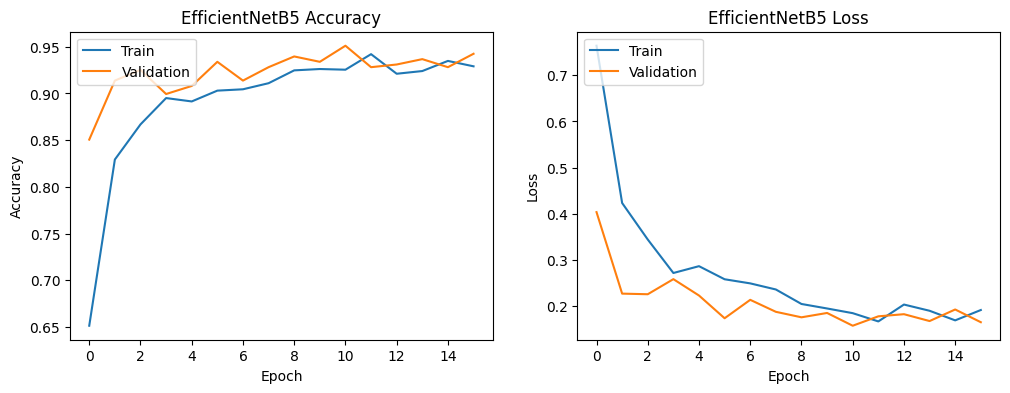

160/160 ━━━━━━━━━━━━━━━━━━━━ 44s 275ms/step - accuracy: 0.9357 - loss: 0.2860
Test Accuracy: 0.7847
160/160 ━━━━━━━━━━━━━━━━━━━━ 58s 295ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.84      0.99      0.91      1645
        rust       0.52      0.04      0.07       275
        scab       0.61      0.58      0.59       630

    accuracy                           0.78      2550
   macro avg       0.66      0.54      0.53      2550
weighted avg       0.75      0.78      0.74      2550



In [11]:
model_name = 'EfficientNetB5'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

EN_B5 = build_and_compile_model_not_trainable(EfficientNetB5, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B5, test_loss, test_acc, training_duration = train_and_plot(EN_B5, model_name, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory_not_trainable)
store_results(model_name, history_EN_B5, test_loss, test_acc, training_duration, results_not_trainable, csv_filename_not_trainable)

## EN B6

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
165234480/165234480 ━━━━━━━━━━━━━━━━━━━━ 65s 0us/step


/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


E0000 00:00:1728992666.312312   15389 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-10-15 18:44:26.573060: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{} for conv (f32[16,56,264,264]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,56,264,264]{3,2,1,0}, f32[56,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=56, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
E0000 00:00:1728992666.842901   15389 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

72/87 ━━━━━━━━━━━━━━━━━━━━ 11s 749ms/step - accuracy: 0.5232 - loss: 0.9433

E0000 00:00:1728992776.075289   15388 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728992776.276172   15388 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728992776.487780   15388 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728992778.915212   15388 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728992779.104168   15388 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5494 - loss: 0.9083

E0000 00:00:1728992840.239183   15390 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728992840.605345   15390 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728992842.082898   15390 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728992842.335963   15390 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-10-15 18:47:25.139042: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{} for conv (f32[12,192,132,132]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,192,265,265]{3,2,1,0},

87/87 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.5510 - loss: 0.9061 - val_accuracy: 0.8937 - val_loss: 0.3173
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 78s 893ms/step - accuracy: 0.8423 - loss: 0.4120 - val_accuracy: 0.9425 - val_loss: 0.2365
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 76s 863ms/step - accuracy: 0.8517 - loss: 0.3659 - val_accuracy: 0.9397 - val_loss: 0.2060
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 73s 838ms/step - accuracy: 0.8960 - loss: 0.2685 - val_accuracy: 0.9224 - val_loss: 0.2259
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 74s 845ms/step - accuracy: 0.8911 - loss: 0.2830 - val_accuracy: 0.9397 - val_loss: 0.1691
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 76s 870ms/step - accuracy: 0.8993 - loss: 0.2506 - val_accuracy: 0.9569 - val_loss: 0.1373
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 75s 860ms/step - accuracy: 0.9302 - loss: 0.1947 - val_accuracy: 0.9598 - val_loss: 0.1394
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 75s 853ms/step - accuracy: 0.9175 - loss: 0.2104 - val_accuracy: 0.9253 

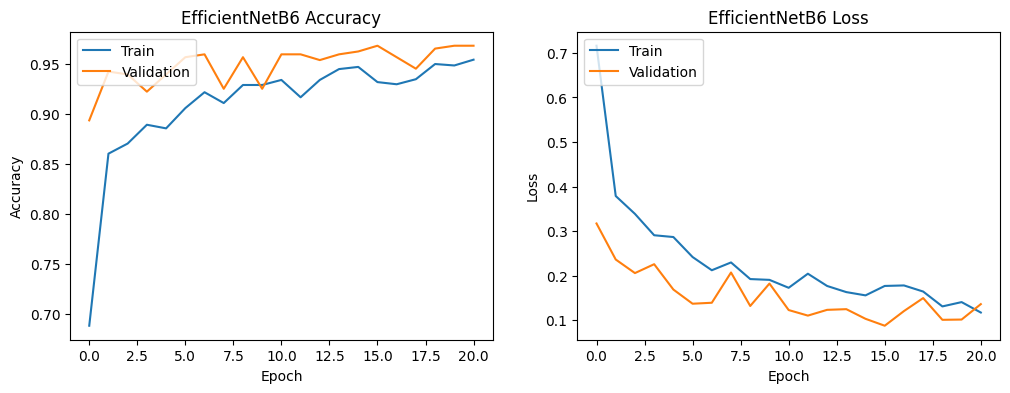

160/160 ━━━━━━━━━━━━━━━━━━━━ 73s 457ms/step - accuracy: 0.9205 - loss: 0.4102
Test Accuracy: 0.7631
160/160 ━━━━━━━━━━━━━━━━━━━━ 91s 491ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.82      0.97      0.89      1645
        rust       0.14      0.00      0.01       275
        scab       0.57      0.54      0.56       630

    accuracy                           0.76      2550
   macro avg       0.51      0.51      0.49      2550
weighted avg       0.69      0.76      0.71      2550



In [12]:
model_name = 'EfficientNetB6'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

EN_B6 = build_and_compile_model_not_trainable(EfficientNetB6, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B6, test_loss, test_acc, training_duration = train_and_plot(EN_B6, model_name, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory_not_trainable)
store_results(model_name, history_EN_B6, test_loss, test_acc, training_duration, results_not_trainable, csv_filename_not_trainable)

## EN B7

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


I0000 00:00:1728996161.271999   20133 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728996161.619651   20133 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728996161.619752   20133 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728996161.627362   20133 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728996161.627448   20133 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Epoch 1/50


I0000 00:00:1728996198.611886   20272 service.cc:146] XLA service 0x7fdd900047e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728996198.612249   20272 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-10-15 19:43:19.749559: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-15 19:43:23.922870: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-15 19:43:36.024150: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng42{k2=1,k4=1,k5=1,k6=0,k7=0} for conv (f32[16,64,300,300]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,300,300]{3,2,1,0}, f32[64,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=64, custom_call_target="__cudnn$convForward", backend_config={"

38/87 ━━━━━━━━━━━━━━━━━━━━ 44s 902ms/step - accuracy: 0.4168 - loss: 1.0721

E0000 00:00:1728996316.914289   20271 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728996317.249501   20271 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728996317.486835   20271 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728996319.519416   20271 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728996319.814303   20271 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5049 - loss: 0.9793

E0000 00:00:1728996427.180048   20272 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-10-15 19:47:07.377923: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{} for conv (f32[12,64,300,300]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,64,300,300]{3,2,1,0}, f32[64,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=64, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
E0000 00:00:1728996427.711474   20272 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

87/87 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.5062 - loss: 0.9776 - val_accuracy: 0.8506 - val_loss: 0.4922
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.8198 - loss: 0.4781 - val_accuracy: 0.8333 - val_loss: 0.3806
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.8555 - loss: 0.4089 - val_accuracy: 0.9023 - val_loss: 0.2751
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.8672 - loss: 0.3379 - val_accuracy: 0.8879 - val_loss: 0.3012
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.8978 - loss: 0.2977 - val_accuracy: 0.9052 - val_loss: 0.2511
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.8921 - loss: 0.3006 - val_accuracy: 0.9253 - val_loss: 0.2159
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.9222 - loss: 0.2086 - val_accuracy: 0.9080 - val_loss: 0.2450
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.8958 - loss: 0.2722 - val_accuracy: 0.9195 - val_loss: 0.229

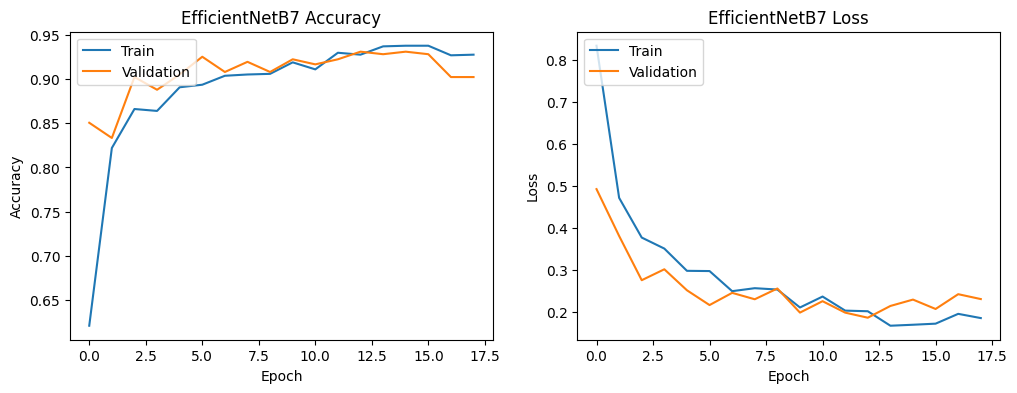

160/160 ━━━━━━━━━━━━━━━━━━━━ 127s 789ms/step - accuracy: 0.9133 - loss: 0.4395
Test Accuracy: 0.7620
160/160 ━━━━━━━━━━━━━━━━━━━━ 147s 820ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.83      0.96      0.89      1645
        rust       0.50      0.01      0.02       275
        scab       0.55      0.56      0.56       630

    accuracy                           0.76      2550
   macro avg       0.63      0.51      0.49      2550
weighted avg       0.73      0.76      0.72      2550



In [9]:
model_name = 'EfficientNetB7'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

EN_B7 = build_and_compile_model_not_trainable(EfficientNetB7, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B7, test_loss, test_acc, training_duration = train_and_plot(EN_B7, model_name, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory_not_trainable)
store_results(model_name, history_EN_B7, test_loss, test_acc, training_duration, results_not_trainable, csv_filename_not_trainable)

# Trainable

## EN B0

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


I0000 00:00:1729007171.702806   30846 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729007172.032866   30846 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729007172.032956   30846 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729007172.037306   30846 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729007172.037396   30846 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Epoch 1/50


I0000 00:00:1729007188.488434   30988 service.cc:146] XLA service 0x7f9be8061300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729007188.488491   30988 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-10-15 22:46:28.912310: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-15 22:46:30.575518: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
E0000 00:00:1729007196.844551   30988 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729007197.135722   30988 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight System

87/87 ━━━━━━━━━━━━━━━━━━━━ 89s 648ms/step - accuracy: 0.3380 - loss: 1.8141 - val_accuracy: 0.5517 - val_loss: 0.9877
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 292ms/step - accuracy: 0.4089 - loss: 1.4856 - val_accuracy: 0.5747 - val_loss: 0.8985
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 281ms/step - accuracy: 0.5046 - loss: 1.2508 - val_accuracy: 0.6494 - val_loss: 0.7994
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 275ms/step - accuracy: 0.5151 - loss: 1.2209 - val_accuracy: 0.6782 - val_loss: 0.7392
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 296ms/step - accuracy: 0.5756 - loss: 1.0126 - val_accuracy: 0.7126 - val_loss: 0.6866
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 288ms/step - accuracy: 0.6266 - loss: 0.9504 - val_accuracy: 0.7385 - val_loss: 0.6440
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 293ms/step - accuracy: 0.6401 - loss: 0.9166 - val_accuracy: 0.7644 - val_loss: 0.6113
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 283ms/step - accuracy: 0.6612 - loss: 0.8645 - val_accuracy: 0.781

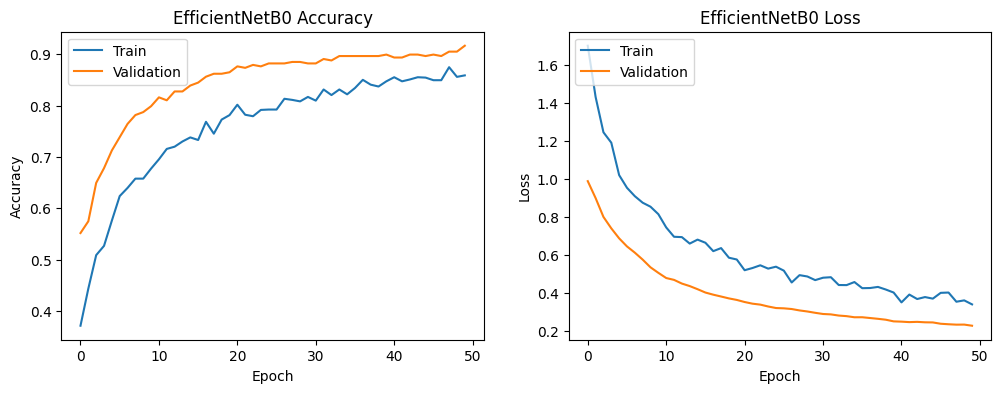

160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.9508 - loss: 0.1871
Test Accuracy: 0.8043
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.83      0.99      0.90      1645
        rust       0.65      0.57      0.61       275
        scab       0.77      0.43      0.55       630

    accuracy                           0.80      2550
   macro avg       0.75      0.66      0.69      2550
weighted avg       0.80      0.80      0.78      2550



In [10]:
model_name = 'EfficientNetB0'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

EN_B0 = build_and_compile_model_trainable(EfficientNetB0, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B0, test_loss, test_acc, training_duration = train_and_plot(EN_B0, model_name, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory_trainable)
store_results(model_name, history_EN_B0, test_loss, test_acc, training_duration, results_not_trainable, csv_filename_trainable)
sleep_reset()

## EN B1

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


E0000 00:00:1729008607.864295   30984 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729008608.165541   30984 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


87/87 ━━━━━━━━━━━━━━━━━━━━ 107s 729ms/step - accuracy: 0.3321 - loss: 1.6711 - val_accuracy: 0.3966 - val_loss: 1.0815
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 310ms/step - accuracy: 0.4001 - loss: 1.4293 - val_accuracy: 0.5230 - val_loss: 0.9709
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 307ms/step - accuracy: 0.4850 - loss: 1.2440 - val_accuracy: 0.6293 - val_loss: 0.8267
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 314ms/step - accuracy: 0.5077 - loss: 1.1814 - val_accuracy: 0.6753 - val_loss: 0.7156
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 307ms/step - accuracy: 0.5639 - loss: 1.0595 - val_accuracy: 0.7126 - val_loss: 0.6516
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 311ms/step - accuracy: 0.6001 - loss: 0.9865 - val_accuracy: 0.7529 - val_loss: 0.5947
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 303ms/step - accuracy: 0.6279 - loss: 0.9114 - val_accuracy: 0.7787 - val_loss: 0.5531
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 290ms/step - accuracy: 0.6327 - loss: 0.8410 - val_accuracy: 0.79

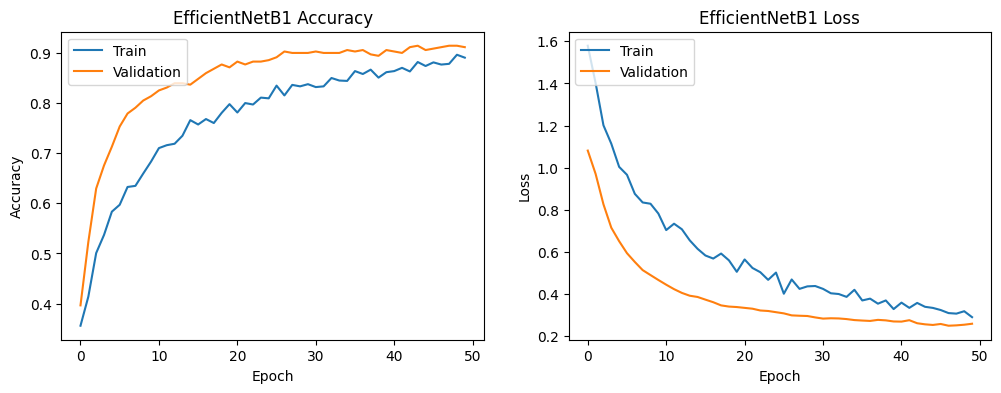

160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.9456 - loss: 0.1765
Test Accuracy: 0.7745
160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.79      1.00      0.88      1645
        rust       0.84      0.24      0.37       275
        scab       0.69      0.43      0.53       630

    accuracy                           0.77      2550
   macro avg       0.77      0.55      0.59      2550
weighted avg       0.77      0.77      0.74      2550



In [11]:
model_name = 'EfficientNetB1'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

EN_B1 = build_and_compile_model_trainable(EfficientNetB1, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B1, test_loss, test_acc, training_duration = train_and_plot(EN_B1, model_name, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory_trainable)
store_results(model_name, history_EN_B1, test_loss, test_acc, training_duration, results_trainable, csv_filename_trainable)
sleep_reset()

## EN B2

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


E0000 00:00:1729010105.553711   30985 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729010105.708756   30985 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729010105.865941   30985 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-10-15 23:35:08.769049: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[16,288,33,33]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,288,33,33]{3,2,1,0}, f32[288,1,5,5]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, feature_group_count=288, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wai

10/87 ━━━━━━━━━━━━━━━━━━━━ 18s 241ms/step - accuracy: 0.2994 - loss: 1.8151

E0000 00:00:1729010134.787852   30987 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729010134.919789   30987 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.3604 - loss: 1.5941

E0000 00:00:1729010186.608502   30986 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729010186.744087   30986 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


87/87 ━━━━━━━━━━━━━━━━━━━━ 113s 802ms/step - accuracy: 0.3610 - loss: 1.5926 - val_accuracy: 0.4626 - val_loss: 1.0409
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 30s 342ms/step - accuracy: 0.4523 - loss: 1.2805 - val_accuracy: 0.6034 - val_loss: 0.8965
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 29s 330ms/step - accuracy: 0.5481 - loss: 1.0531 - val_accuracy: 0.7011 - val_loss: 0.7430
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 29s 337ms/step - accuracy: 0.5947 - loss: 0.9497 - val_accuracy: 0.7328 - val_loss: 0.6375
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 29s 331ms/step - accuracy: 0.5847 - loss: 0.9850 - val_accuracy: 0.7644 - val_loss: 0.5592
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 29s 326ms/step - accuracy: 0.6625 - loss: 0.8053 - val_accuracy: 0.7931 - val_loss: 0.5144
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 29s 332ms/step - accuracy: 0.6981 - loss: 0.7346 - val_accuracy: 0.8075 - val_loss: 0.4741
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 30s 340ms/step - accuracy: 0.7034 - loss: 0.7377 - val_accuracy: 0.82

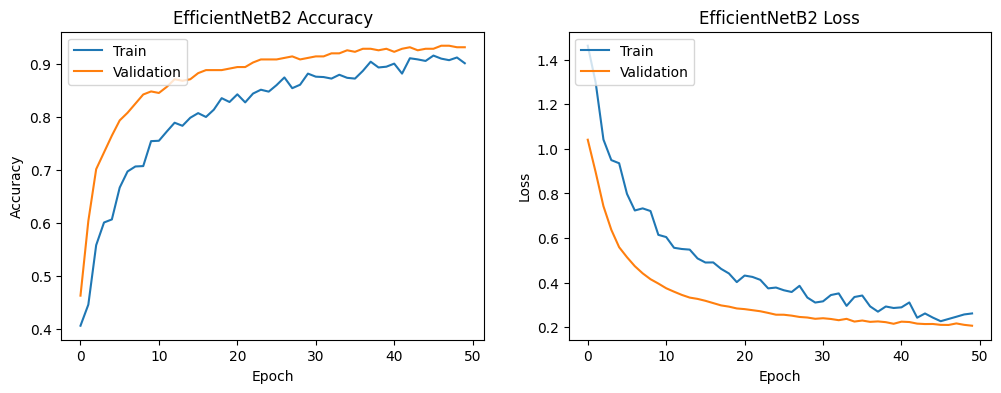

160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9525 - loss: 0.2046
Test Accuracy: 0.8271
160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.85      0.99      0.92      1645
        rust       0.92      0.37      0.52       275
        scab       0.72      0.60      0.65       630

    accuracy                           0.83      2550
   macro avg       0.83      0.65      0.70      2550
weighted avg       0.83      0.83      0.81      2550



In [12]:
model_name = 'EfficientNetB2'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

EN_B2 = build_and_compile_model_trainable(EfficientNetB2, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B2, test_loss, test_acc, training_duration = train_and_plot(EN_B2, model_name, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory_trainable)
store_results(model_name, history_EN_B2, test_loss, test_acc, training_duration, results_trainable, csv_filename_trainable)
sleep_reset()

## EN B3

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


E0000 00:00:1729011721.885116   30986 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729011722.059365   30986 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729011722.229139   30986 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729011729.471821   30986 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-10-16 00:02:09.891207: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng18{k11=2} for conv (f32[1392,1,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,1392,10,10]{3,2,1,0}

36/87 ━━━━━━━━━━━━━━━━━━━━ 16s 322ms/step - accuracy: 0.3130 - loss: 1.6504

E0000 00:00:1729011765.918196   30986 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729011766.054563   30986 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.3429 - loss: 1.5949

E0000 00:00:1729011817.988312   30985 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729011818.163880   30985 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729011818.310504   30985 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


87/87 ━━━━━━━━━━━━━━━━━━━━ 136s 955ms/step - accuracy: 0.3435 - loss: 1.5936 - val_accuracy: 0.4368 - val_loss: 1.0511
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 35s 395ms/step - accuracy: 0.4779 - loss: 1.2235 - val_accuracy: 0.5517 - val_loss: 0.9281
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 34s 389ms/step - accuracy: 0.5369 - loss: 1.0630 - val_accuracy: 0.6897 - val_loss: 0.7427
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 34s 386ms/step - accuracy: 0.6472 - loss: 0.8621 - val_accuracy: 0.7299 - val_loss: 0.6073
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 33s 379ms/step - accuracy: 0.6677 - loss: 0.8064 - val_accuracy: 0.7759 - val_loss: 0.5186
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 34s 393ms/step - accuracy: 0.7116 - loss: 0.7055 - val_accuracy: 0.7989 - val_loss: 0.4670
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 34s 385ms/step - accuracy: 0.7129 - loss: 0.7119 - val_accuracy: 0.8276 - val_loss: 0.4215
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 33s 382ms/step - accuracy: 0.7187 - loss: 0.6310 - val_accuracy: 0.83

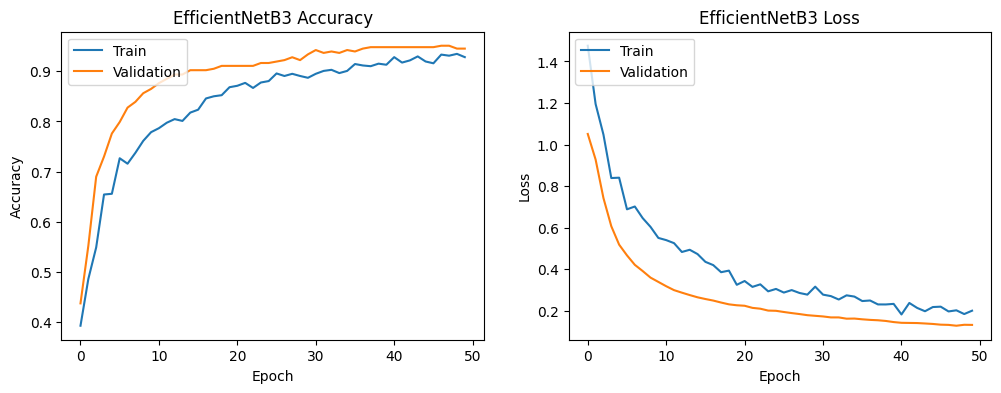

160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.9510 - loss: 0.1901
Test Accuracy: 0.8165
160/160 ━━━━━━━━━━━━━━━━━━━━ 25s 111ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.83      1.00      0.91      1645
        rust       0.96      0.17      0.28       275
        scab       0.76      0.63      0.69       630

    accuracy                           0.82      2550
   macro avg       0.85      0.60      0.63      2550
weighted avg       0.82      0.82      0.78      2550



In [13]:
model_name = 'EfficientNetB3'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

EN_B3 = build_and_compile_model_trainable(EfficientNetB3, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B3, test_loss, test_acc, training_duration = train_and_plot(EN_B3, model_name, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory_trainable)
store_results(model_name, history_EN_B3, test_loss, test_acc, training_duration, results_trainable, csv_filename_trainable)
sleep_reset()

## EN B4

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


I0000 00:00:1729027094.487384   40905 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729027094.861939   40905 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729027094.862040   40905 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729027094.868366   40905 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729027094.868755   40905 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Epoch 1/50


I0000 00:00:1729027124.166036   41048 service.cc:146] XLA service 0x7f7f100051a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729027124.166086   41048 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-10-16 04:18:45.031316: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-16 04:18:48.341607: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
E0000 00:00:1729027137.088538   41048 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729027137.271041   41048 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight System

84/87 ━━━━━━━━━━━━━━━━━━━━ 1s 461ms/step - accuracy: 0.4040 - loss: 1.4673

E0000 00:00:1729027217.362349   41048 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729027217.512005   41048 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729027219.459449   41048 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729027223.244081   41048 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729027223.570757   41048 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 882ms/step - accuracy: 0.4055 - loss: 1.4636

E0000 00:00:1729027261.842881   41050 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729027262.009898   41050 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


87/87 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.4060 - loss: 1.4624 - val_accuracy: 0.5057 - val_loss: 1.0260
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 45s 519ms/step - accuracy: 0.5252 - loss: 1.1303 - val_accuracy: 0.6667 - val_loss: 0.8116
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 46s 523ms/step - accuracy: 0.6219 - loss: 0.9057 - val_accuracy: 0.7615 - val_loss: 0.6019
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 44s 506ms/step - accuracy: 0.6741 - loss: 0.8045 - val_accuracy: 0.7989 - val_loss: 0.4729
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 45s 514ms/step - accuracy: 0.7295 - loss: 0.6837 - val_accuracy: 0.8247 - val_loss: 0.4046
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 46s 520ms/step - accuracy: 0.7454 - loss: 0.6000 - val_accuracy: 0.8534 - val_loss: 0.3533
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 45s 508ms/step - accuracy: 0.7970 - loss: 0.5453 - val_accuracy: 0.8736 - val_loss: 0.3154
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 45s 514ms/step - accuracy: 0.8209 - loss: 0.4465 - val_accuracy: 0.8793 

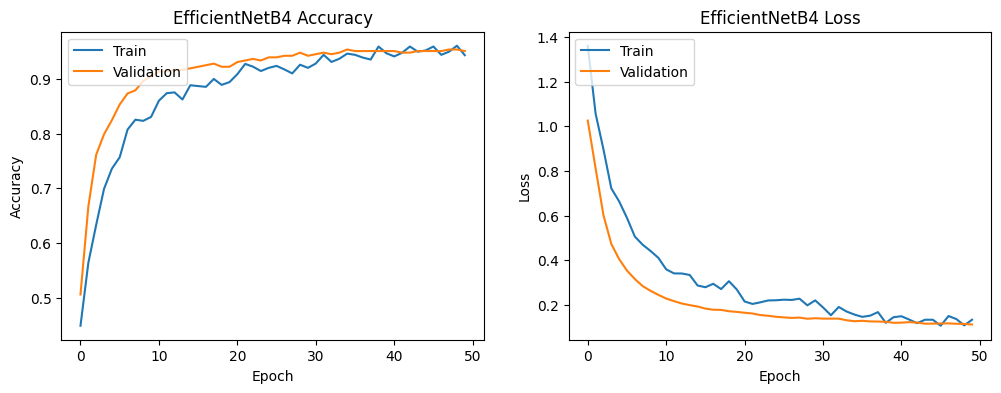

160/160 ━━━━━━━━━━━━━━━━━━━━ 23s 146ms/step - accuracy: 0.8772 - loss: 0.3660
Test Accuracy: 0.8365
160/160 ━━━━━━━━━━━━━━━━━━━━ 36s 168ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.96      0.91      0.93      1645
        rust       0.90      0.23      0.37       275
        scab       0.62      0.90      0.74       630

    accuracy                           0.84      2550
   macro avg       0.83      0.68      0.68      2550
weighted avg       0.87      0.84      0.82      2550



In [10]:
model_name = 'EfficientNetB4'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

EN_B4 = build_and_compile_model_trainable(EfficientNetB4, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B4, test_loss, test_acc, training_duration = train_and_plot(EN_B4, model_name, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory_trainable)
store_results(model_name, history_EN_B4, test_loss, test_acc, training_duration, results_trainable, csv_filename_trainable)
sleep_reset()

## EN B5

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


E0000 00:00:1729029605.027484   41050 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729029605.368776   41050 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729029606.497083   41050 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729029606.710879   41050 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-10-16 05:00:09.192138: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{} for conv (f32[16,144,114,114]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,144,229,229]{3,2,1,0},

37/87 ━━━━━━━━━━━━━━━━━━━━ 30s 613ms/step - accuracy: 0.3595 - loss: 1.6818

E0000 00:00:1729029693.706641   41049 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729029693.882536   41049 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729029695.962203   41049 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729029696.156206   41049 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-10-16 05:01:38.448505: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.40GiB with freed_by_count=0. The caller indicates that thi

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3762 - loss: 1.5898

E0000 00:00:1729029780.488029   41048 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729029780.683715   41048 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729029780.880077   41048 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729029783.877019   41048 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729029784.065649   41048 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

87/87 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.3766 - loss: 1.5882 - val_accuracy: 0.5287 - val_loss: 1.0122
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 64s 724ms/step - accuracy: 0.5442 - loss: 1.0480 - val_accuracy: 0.7241 - val_loss: 0.7696
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 63s 715ms/step - accuracy: 0.6469 - loss: 0.8443 - val_accuracy: 0.7989 - val_loss: 0.5262
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 64s 726ms/step - accuracy: 0.7220 - loss: 0.6796 - val_accuracy: 0.8534 - val_loss: 0.3913
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 62s 711ms/step - accuracy: 0.7543 - loss: 0.6000 - val_accuracy: 0.8851 - val_loss: 0.3238
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 61s 699ms/step - accuracy: 0.8056 - loss: 0.4870 - val_accuracy: 0.8994 - val_loss: 0.2800
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 61s 694ms/step - accuracy: 0.8394 - loss: 0.4263 - val_accuracy: 0.9023 - val_loss: 0.2541
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 59s 677ms/step - accuracy: 0.8601 - loss: 0.4113 - val_accuracy: 0.9138 

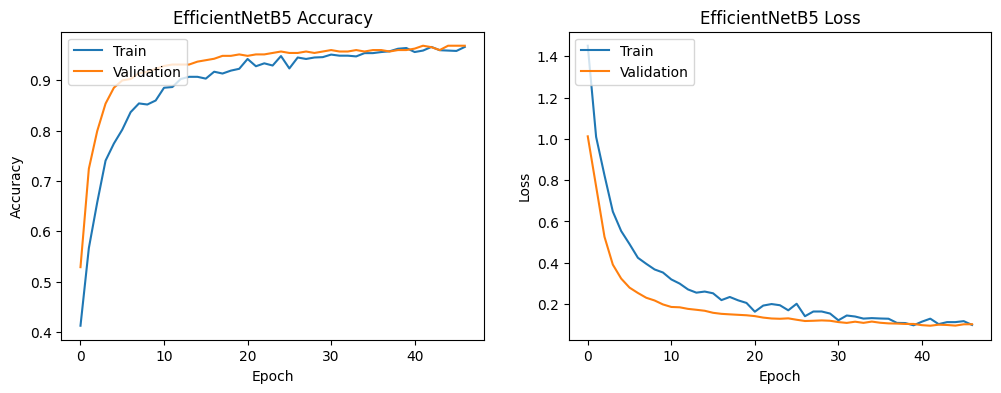

160/160 ━━━━━━━━━━━━━━━━━━━━ 46s 286ms/step - accuracy: 0.9383 - loss: 0.2864
Test Accuracy: 0.8243
160/160 ━━━━━━━━━━━━━━━━━━━━ 61s 304ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.91      0.98      0.94      1645
        rust       0.65      0.07      0.13       275
        scab       0.63      0.74      0.69       630

    accuracy                           0.82      2550
   macro avg       0.73      0.60      0.59      2550
weighted avg       0.81      0.82      0.79      2550



In [11]:
model_name = 'EfficientNetB5'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

EN_B5 = build_and_compile_model_trainable(EfficientNetB5, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B5, test_loss, test_acc, training_duration = train_and_plot(EN_B5, model_name, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory_trainable)
store_results(model_name, history_EN_B5, test_loss, test_acc, training_duration, results_trainable, csv_filename_trainable)
sleep_reset()

## EN B6

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


I0000 00:00:1729047617.422654   46024 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729047617.754888   46024 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729047617.755138   46024 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729047617.760546   46024 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729047617.760661   46024 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Epoch 1/50


I0000 00:00:1729047662.109866   47005 service.cc:146] XLA service 0x7f96fc115570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729047662.109919   47005 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-10-16 10:01:03.370068: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-16 10:01:08.167467: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
E0000 00:00:1729047682.002292   47005 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-10-16 10:01:22.256348: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{} for conv (f32[16,56,264,264]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,56,264,264]{3,2

44/87 ━━━━━━━━━━━━━━━━━━━━ 33s 778ms/step - accuracy: 0.3678 - loss: 1.4346

E0000 00:00:1729047791.418479   47005 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729047791.637361   47005 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729047794.495699   47005 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729047794.690541   47005 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729047799.508025   47005 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3985 - loss: 1.3885

E0000 00:00:1729047891.290745   47006 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729047891.668747   47006 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-10-16 10:04:51.702202: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{} for conv (f32[12,56,264,264]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,56,264,264]{3,2,1,0}, f32[56,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=56, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-

87/87 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.3990 - loss: 1.3875 - val_accuracy: 0.3649 - val_loss: 1.0878
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 78s 885ms/step - accuracy: 0.5697 - loss: 0.9897 - val_accuracy: 0.4138 - val_loss: 0.9639
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 79s 896ms/step - accuracy: 0.6692 - loss: 0.7511 - val_accuracy: 0.6580 - val_loss: 0.7005
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 80s 910ms/step - accuracy: 0.7403 - loss: 0.5724 - val_accuracy: 0.8075 - val_loss: 0.4721
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 78s 886ms/step - accuracy: 0.8191 - loss: 0.4710 - val_accuracy: 0.8937 - val_loss: 0.3213
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 79s 905ms/step - accuracy: 0.8354 - loss: 0.4093 - val_accuracy: 0.9195 - val_loss: 0.2527
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 80s 907ms/step - accuracy: 0.8613 - loss: 0.3349 - val_accuracy: 0.9310 - val_loss: 0.2177
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 80s 908ms/step - accuracy: 0.8916 - loss: 0.2953 - val_accuracy: 0.9397 

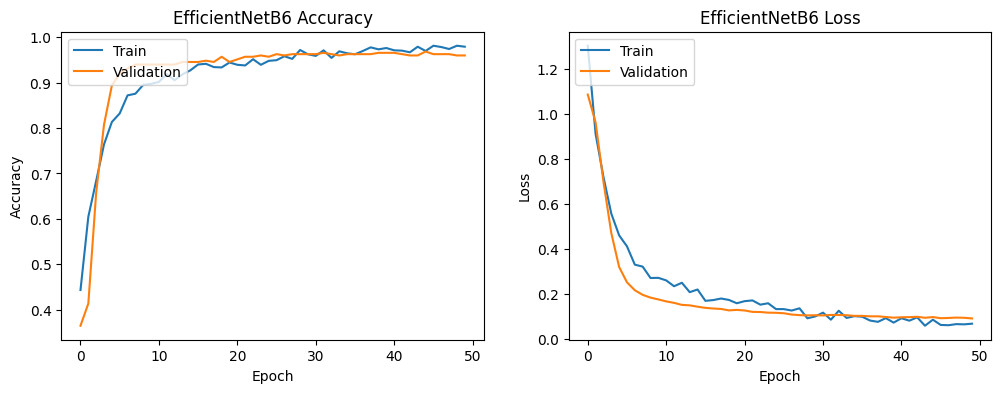

160/160 ━━━━━━━━━━━━━━━━━━━━ 75s 465ms/step - accuracy: 0.9229 - loss: 0.2861
Test Accuracy: 0.8157
160/160 ━━━━━━━━━━━━━━━━━━━━ 95s 503ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.86      0.96      0.91      1645
        rust       0.91      0.23      0.37       275
        scab       0.67      0.68      0.68       630

    accuracy                           0.82      2550
   macro avg       0.82      0.63      0.65      2550
weighted avg       0.82      0.82      0.79      2550



In [10]:
model_name = 'EfficientNetB6'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

EN_B6 = build_and_compile_model_trainable(EfficientNetB6, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B6, test_loss, test_acc, training_duration = train_and_plot(EN_B6, model_name, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory_trainable)
store_results(model_name, history_EN_B6, test_loss, test_acc, training_duration, results_trainable, csv_filename_trainable)
sleep_reset()

## EN B7

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


I0000 00:00:1729052250.009823   49604 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729052250.480854   49604 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729052250.480934   49604 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729052250.486095   49604 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729052250.486203   49604 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Epoch 1/50


I0000 00:00:1729052303.478815   49747 service.cc:146] XLA service 0x7fcb840026d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729052303.478990   49747 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-10-16 11:18:24.987659: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-16 11:18:30.646153: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-16 11:18:46.774699: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng42{k2=1,k4=1,k5=1,k6=0,k7=0} for conv (f32[16,64,300,300]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,300,300]{3,2,1,0}, f32[64,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=64, custom_call_target="__cudnn$convForward", backend_config={"

76/87 ━━━━━━━━━━━━━━━━━━━━ 10s 993ms/step - accuracy: 0.3884 - loss: 1.5732

E0000 00:00:1729052492.788124   49745 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729052493.051202   49745 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729052493.282208   49745 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729052495.333654   49745 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729052495.633551   49745 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3946 - loss: 1.5497

2024-10-16 11:23:09.486366: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{} for conv (f32[12,64,300,300]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,64,300,300]{3,2,1,0}, f32[64,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=64, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
E0000 00:00:1729052589.590701   49744 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729052590.108894   49744 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

87/87 ━━━━━━━━━━━━━━━━━━━━ 364s 3s/step - accuracy: 0.3951 - loss: 1.5477 - val_accuracy: 0.3362 - val_loss: 1.1649
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.5959 - loss: 0.9644 - val_accuracy: 0.4971 - val_loss: 1.0921
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.7472 - loss: 0.6149 - val_accuracy: 0.6523 - val_loss: 0.7870
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.8207 - loss: 0.4826 - val_accuracy: 0.8161 - val_loss: 0.4912
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.8514 - loss: 0.3947 - val_accuracy: 0.8592 - val_loss: 0.3364
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.8567 - loss: 0.3763 - val_accuracy: 0.8937 - val_loss: 0.2669
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.8640 - loss: 0.3696 - val_accuracy: 0.9023 - val_loss: 0.2251
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.8775 - loss: 0.3269 - val_accuracy: 0.9080 - val_loss: 0.

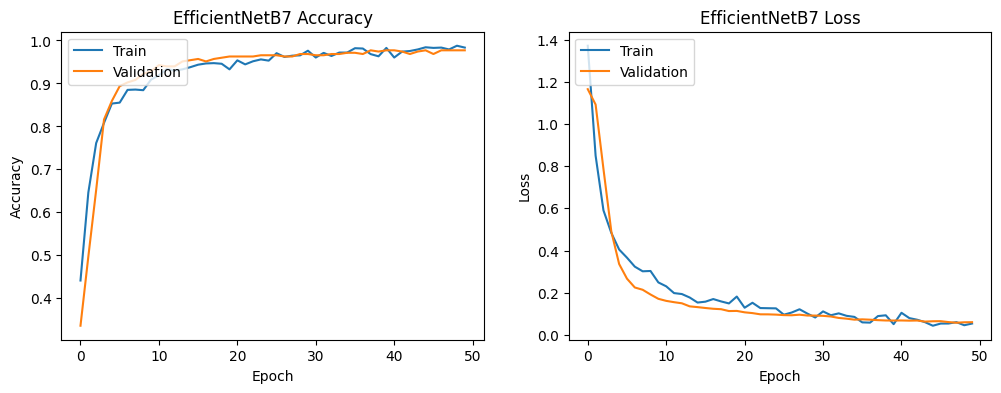

160/160 ━━━━━━━━━━━━━━━━━━━━ 127s 793ms/step - accuracy: 0.9479 - loss: 0.2047
Test Accuracy: 0.8404
160/160 ━━━━━━━━━━━━━━━━━━━━ 155s 843ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.89      0.99      0.94      1645
        rust       0.95      0.21      0.35       275
        scab       0.70      0.73      0.71       630

    accuracy                           0.84      2550
   macro avg       0.85      0.64      0.66      2550
weighted avg       0.85      0.84      0.82      2550



In [10]:
model_name = 'EfficientNetB7'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

EN_B7 = build_and_compile_model_trainable(EfficientNetB7, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B7, test_loss, test_acc, training_duration = train_and_plot(EN_B7, model_name, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory_trainable)
store_results(model_name, history_EN_B7, test_loss, test_acc, training_duration, results_trainable, csv_filename_trainable)
sleep_reset()

# Kesimpulan

In [4]:
results_df_not_trainable = pd.read_csv(csv_filename_not_trainable)
results_df_not_trainable[['Model','Train Accuracy','Validation Accuracy','Test Accuracy','Training Duration','Total Epoch']]

,Model,Train Accuracy,Validation Accuracy,Test Accuracy,Training Duration,Total Epoch
0,EfficientNetB0,0.899421,0.922414,0.756078,339.581339,11
1,EfficientNetB1,0.913169,0.928161,0.793333,662.413689,22
2,EfficientNetB2,0.916787,0.908046,0.771373,674.246198,21
3,EfficientNetB3,0.930535,0.925287,0.806275,854.126141,23
4,EfficientNetB4,0.932706,0.945402,0.772157,832.431913,16
5,EfficientNetB5,0.942113,0.951149,0.784706,1036.612290,15
6,EfficientNetB6,0.954414,0.968391,0.763137,1740.369936,20
7,EfficientNetB7,0.937771,0.931035,0.761961,1995.886590,17


In [5]:
results_df_trainable = pd.read_csv(csv_filename_trainable)
results_df_trainable[['Model','Train Accuracy','Validation Accuracy','Test Accuracy','Training Duration','Total Epoch']]

,Model,Train Accuracy,Validation Accuracy,Test Accuracy,Training Duration,Total Epoch
0,EfficientNetB0,0.874819,0.916667,0.804314,1316.130972,49
1,EfficientNetB1,0.895803,0.913793,0.774510,1410.510168,49
2,EfficientNetB2,0.915340,0.933908,0.827059,1514.367601,49
3,EfficientNetB3,0.934877,0.951149,0.816471,1766.225940,49
4,EfficientNetB4,0.960926,0.954023,0.836471,2320.409158,49
5,EfficientNetB5,0.965991,0.968391,0.824314,2958.937836,46
6,EfficientNetB6,0.981187,0.968391,0.815686,4128.812377,49
7,EfficientNetB7,0.987699,0.977012,0.840392,5615.501943,49


In [7]:
best_model = results_df_not_trainable.loc[results_df_not_trainable['Test Accuracy'].idxmax(), 'Model']
print("Model not trainable yang memiliki nilai test acc tertinggi: ",best_model)

best_model = results_df_trainable.loc[results_df_trainable['Test Accuracy'].idxmax(), 'Model']
print("Model trainable yang memiliki nilai test acc tertinggi: ",best_model)

Model not trainable yang memiliki nilai test acc tertinggi:  EfficientNetB3
Model trainable yang memiliki nilai test acc tertinggi:  EfficientNetB7


# Test best model terhadap dataset cadangan (downsampled & segmented)

## EDA

- Nampilin jumlah masing-masing kelas
- Nampilin jumlah masing-masing kelas setelah di downsampled

## Not trainable downsampled

## Not trainable segmented

## Trainable downsampled

## Trainable segmented

# Train best model not_trainable and trainable menggunakan dataset cadangan

## Define Fungsi

In [2]:
base_path = "data/split_train_test_dataset_campuran"

## Not Trainable (EN B3)

Found 2550 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 1382 images belonging to 3 classes.
Epoch 1/10
80/80 [==============================] - 82s 903ms/step - loss: 0.2651 - accuracy: 0.9020
Epoch 2/10
80/80 [==============================] - 74s 922ms/step - loss: 0.0773 - accuracy: 0.9737
Epoch 3/10
80/80 [==============================] - 73s 913ms/step - loss: 0.0550 - accuracy: 0.9827
Epoch 4/10
80/80 [==============================] - 73s 912ms/step - loss: 0.0360 - accuracy: 0.9875
Epoch 5/10
80/80 [==============================] - 74s 926ms/step - loss: 0.0468 - accuracy: 0.9820
Epoch 6/10
80/80 [==============================] - 75s 941ms/step - loss: 0.0450 - accuracy: 0.9867
Epoch 7/10
80/80 [==============================] - 73s 916ms/step - loss: 0.0310 - accuracy: 0.9886
Epoch 8/10
80/80 [==============================] - 73s 911ms/step - loss: 0.0257 - accuracy: 0.9918
Epoch 9/10
80/80 [==============================] - 74s 919ms/step 

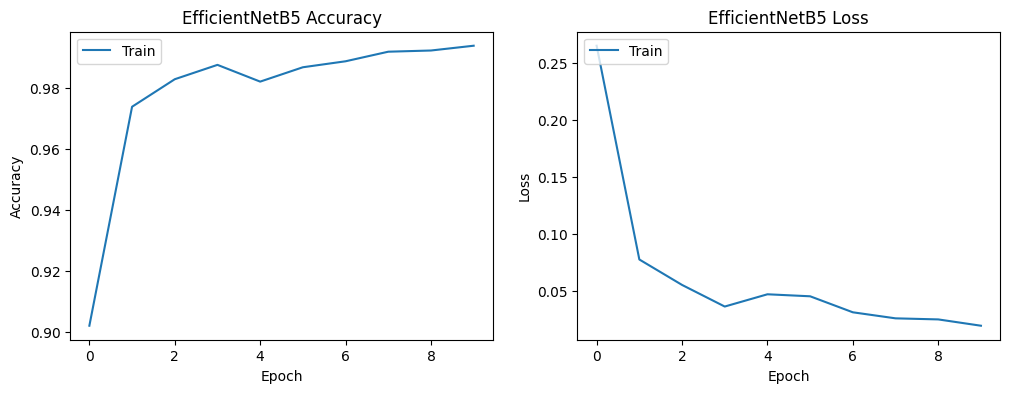

44/44 [==============================] - 19s 371ms/step - loss: 1.7294 - accuracy: 0.5333
Test Accuracy: 0.5333
44/44 [==============================] - 19s 371ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.79      0.43      0.55       412
        rust       0.60      0.38      0.46       497
        scab       0.44      0.79      0.57       473

    accuracy                           0.53      1382
   macro avg       0.61      0.53      0.53      1382
weighted avg       0.60      0.53      0.53      1382



In [17]:
model_name = 'EfficientNetB3'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

EN_B5 = build_and_compile_model_not_trainable(EfficientNetB5, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B5, test_loss, test_acc, training_duration = train_and_plot(EN_B5, model_name, train_generator, validation_generator, test_generator, epochs = 10, save_directory=save_directory_not_trainable)

## Trainable (EN B7)

Found 2550 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 1382 images belonging to 3 classes.


2024-10-13 06:22:36.636558: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22282 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/10


2024-10-13 06:22:48.614054: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-10-13 06:22:49.108465: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-10-13 06:22:49.244380: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-10-13 06:22:51.222354: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7cdb04da0180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-13 06:22:51.222377: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-10-13 06:22:51.226186: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-13 06:22:51.325090: I ./tensorflow/compiler/jit/device_comp

80/80 [==============================] - 48s 406ms/step - loss: 1.1006 - accuracy: 0.5494
Epoch 2/10
80/80 [==============================] - 34s 418ms/step - loss: 0.5968 - accuracy: 0.7529
Epoch 3/10
80/80 [==============================] - 33s 413ms/step - loss: 0.4105 - accuracy: 0.8439
Epoch 4/10
80/80 [==============================] - 32s 404ms/step - loss: 0.3041 - accuracy: 0.8910
Epoch 5/10
80/80 [==============================] - 34s 420ms/step - loss: 0.2245 - accuracy: 0.9275
Epoch 6/10
80/80 [==============================] - 32s 402ms/step - loss: 0.1965 - accuracy: 0.9400
Epoch 7/10
80/80 [==============================] - 33s 411ms/step - loss: 0.1757 - accuracy: 0.9463
Epoch 8/10
80/80 [==============================] - 33s 406ms/step - loss: 0.1383 - accuracy: 0.9604
Epoch 9/10
80/80 [==============================] - 33s 407ms/step - loss: 0.1214 - accuracy: 0.9643
Epoch 10/10
80/80 [==============================] - 33s 406ms/step - loss: 0.1073 - accuracy: 0.9698


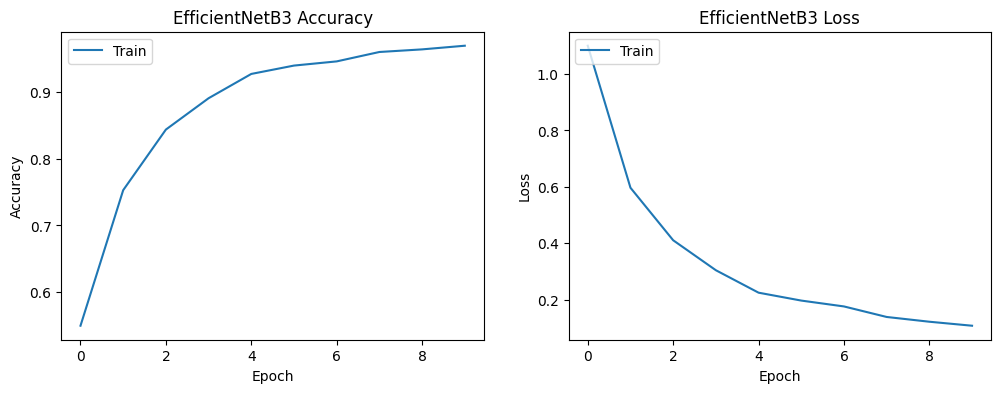

44/44 [==============================] - 14s 282ms/step - loss: 2.4915 - accuracy: 0.3596
Test Accuracy: 0.3596
44/44 [==============================] - 15s 288ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.86      0.03      0.06       412
        rust       0.39      0.11      0.17       497
        scab       0.35      0.91      0.51       473

    accuracy                           0.36      1382
   macro avg       0.53      0.35      0.24      1382
weighted avg       0.52      0.36      0.25      1382



In [8]:
model_name = 'EfficientNetB7'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

EN_B3 = build_and_compile_model_trainable(EfficientNetB3, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B3, test_loss, test_acc, training_duration = train_and_plot(EN_B3, model_name, train_generator, validation_generator, test_generator, epochs = 10, save_directory=save_directory_trainable)

# Retrain trainable dengan freeze layer 50%

## EN B7

# Modifikasi

## Modifikasi not trainable (ENB3)

## Modifikasi trainable (ENB7)